In [1]:
import numpy as np

%matplotlib notebook
import matplotlib.pyplot as plt

import astropy.units as u
from astropy.timeseries import BoxLeastSquares


In [2]:
data = np.genfromtxt('target_PDCSAP_flattened_biweight_1.dat')

time = data[:,0]
flux = data[:,1]
flux_err = data[:,2]


In [3]:
# BLS
model_bls = BoxLeastSquares(time, flux, dy=flux_err)
periodogram = model_bls.autopower(0.1, minimum_period=0.3, maximum_period=30, minimum_n_transit=3,  objective="snr")
# pay attention to the maximum period

<IPython.core.display.Javascript object>


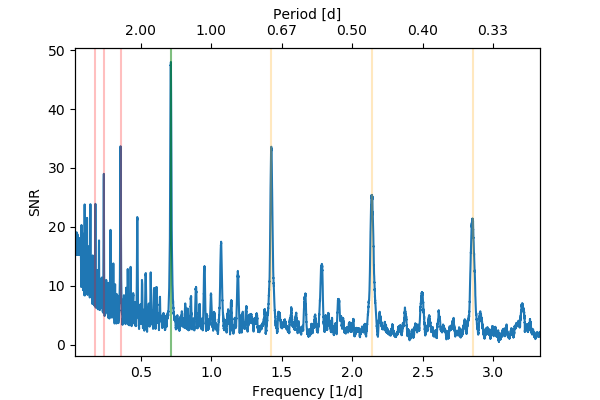

In [4]:
#The periodogram in the frequency scale:

from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import FuncFormatter

fig = plt.figure(figsize=(6,4))
ax1 = fig.add_subplot(111)

ax1.plot(1./periodogram.period, periodogram.power)

ax1.set_xlabel("Frequency [1/d]")
ax1.set_ylabel("SNR")

plt.setp(ax1.get_xticklabels(), visible=False)

ax2 = ax1.twiny()
ax1.get_shared_x_axes().join(ax1,ax2)

ax1.set_xlim(np.amin(1./periodogram.period), np.amax(1./periodogram.period))


f = lambda q: 1./q
finv = lambda x: 1./x
ax2.xaxis.set_major_formatter(FuncFormatter(lambda k,pos: f"{finv(k):.2f}"))
ax2.set_xlabel('Period [d]')

known_period = 1.4013788 #Kokori et al 2022

#multiple of the period
for ii in range(2,5):
    ax1.axvline(1./(ii*known_period), c='red', alpha=0.25)

#fraction of periods
for ii in range(2,10):
    ax1.axvline(1./(known_period/ii), c='orange', alpha=0.25)

ax1.axvline(1./known_period, c='green', alpha=0.5)
plt.show()

<IPython.core.display.Javascript object>


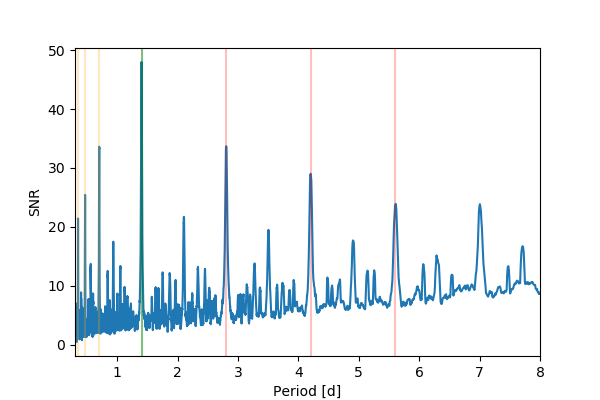

In [5]:
#The periodogram in the period scale:

plt.figure(figsize=(6,4))

plt.plot(periodogram.period, periodogram.power)

plt.xlabel("Period [d]")
plt.ylabel("SNR")

plt.xlim(np.amin(periodogram.period), np.amax(periodogram.period))
plt.xlim(np.amin(periodogram.period), 8)

# multiple of the period
for ii in range(2,5):
    plt.axvline(ii*known_period, c='red', alpha=0.25)

# fraction of period
for ii in range(2,10):
    plt.axvline(known_period/ii, c='orange', alpha=0.25)

plt.axvline(known_period, c='green', alpha=0.5)
plt.show()

## Choosing the most prominent peak


Period with max Power: P= 1.4007 days, Tc = 2459011.9111. 
Depth and duration: 0.0106 %, T14 = 0.1000. 
Alternative Epoch: 2459034.322330718


<IPython.core.display.Javascript object>


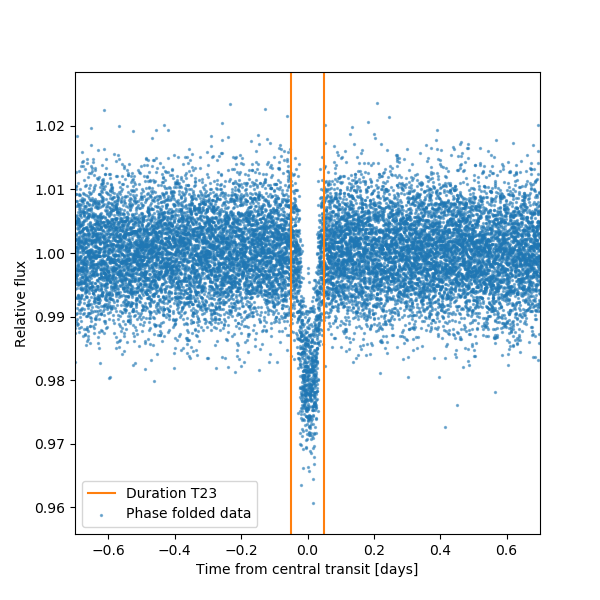

In [6]:
max_power = np.argmax(periodogram.power)
period_bls = periodogram.period[max_power]
epoch_bls = periodogram.transit_time[max_power]
depth_bls = (periodogram.depth[max_power])
duration_bls = periodogram.duration[max_power]

print('Period with max Power: P= {:.4f} days, Tc = {:.4f}. '
      .format(period_bls, epoch_bls))
print('Depth and duration: {:.4f} %, T14 = {:.4f}. '
      .format(depth_bls, duration_bls))

# Compute stats:
stats = model_bls.compute_stats(periodogram.period[max_power],
                            periodogram.duration[max_power],
                            periodogram.transit_time[max_power])

print('Alternative Epoch: {}'.format(stats['transit_times'][-1]))
epoch_bls = stats['transit_times'][0]

# phase fold plot:
phase = (time - epoch_bls) % period_bls / period_bls
phase[np.where(phase>0.5)] -= 1 


## plot the phase fold
plt.figure(figsize=(6,6))
plt.scatter(phase*period_bls, flux, c='C0', s=2, alpha=0.5, label='Phase folded data')
plt.xlim(-period_bls/2, period_bls/2.)

plt.axvline(-duration_bls/2, c='C1', label='Duration T23')
plt.axvline(duration_bls/2, c='C1')

plt.xlabel("Time from central transit [days]")
plt.ylabel("Relative flux")
plt.legend()
plt.show()

In [11]:
# TLS 
from transitleastsquares import transitleastsquares
model_tls = transitleastsquares(time, flux)
results = model_tls.power()

  0%|          | 0/2166 periods | 00:00<?

Transit Least Squares TLS 1.0.31 (22 Nov 2021)
Creating model cache for 37 durations
Searching 16092 data points, 2166 periods from 0.601 to 12.133 days
Using all 12 CPU threads


100%|██████████| 2166/2166 periods | 00:14<00:00


Searching for best T0 for period 1.40131 days


In [12]:
print('Period', format(results.period, '.5f'), 'd')
print(len(results.transit_times), 'transit times in time series:', \
        ['{0:0.5f}'.format(i) for i in results.transit_times])

# NOTE: also the transit time not corresponding to any points will be selected.

print('Normalized flux at the center of transit', format(results.depth, '.5f'))
print('Best duration (days)', format(results.duration, '.5f'))
print('Signal detection efficiency (SDE):', results.SDE)


Period 1.40131 d
17 transit times in time series: ['2459011.91030', '2459013.31162', '2459014.71293', '2459016.11425', '2459017.51556', '2459018.91688', '2459020.31819', '2459021.71951', '2459023.12082', '2459024.52214', '2459025.92345', '2459027.32477', '2459028.72608', '2459030.12740', '2459031.52871', '2459032.93003', '2459034.33134']
Normalized flux at the center of transit 0.98057
Best duration (days) 0.05714
Signal detection efficiency (SDE): 19.027538759126873


<IPython.core.display.Javascript object>


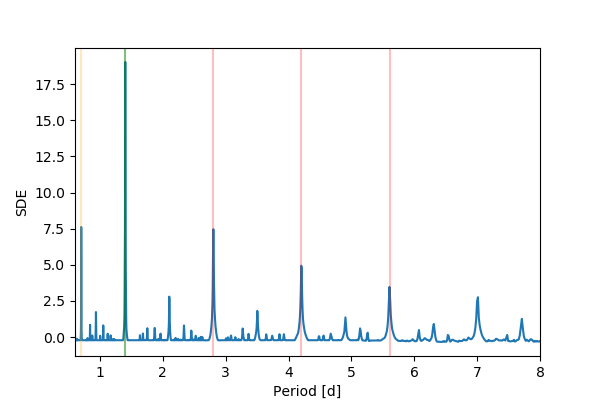

In [13]:
plt.figure(figsize=(6,4))

plt.plot(results.periods, results.power)
# Note: here is periods 

plt.xlabel("Period [d]")
plt.ylabel(r'SDE')

plt.xlim(np.amin(results.periods), 8.)

# multiple of the period
for ii in range(2,5):
    plt.axvline(ii*known_period, c='red', alpha=0.25)

# fraction of period
for ii in range(2,10):
    plt.axvline(known_period/ii, c='orange', alpha=0.25)

plt.axvline(known_period, c='green', alpha=0.5)

plt.show()

<IPython.core.display.Javascript object>


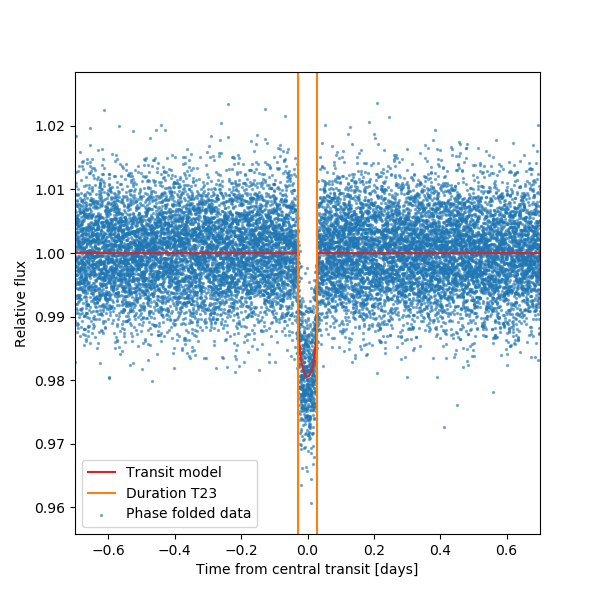

In [14]:
plt.figure(figsize=(6,6))
plt.scatter((results.folded_phase-0.5)*results.period, results.folded_y, c='C0', s=2, alpha=0.5, label='Phase folded data')
plt.plot((results.model_folded_phase-0.5)*results.period, results.model_folded_model, color='C3', label='Transit model')


plt.xlim(-results.period/2, results.period/2.)

plt.axvline(-results.duration/2, c='C1', label='Duration T23')
plt.axvline(results.duration/2, c='C1')
plt.legend()

plt.xlabel("Time from central transit [days]")
plt.ylabel("Relative flux");